# 📘 Estudo sobre IFRS 9: Simulação de Dados e Modelagem de Perda Esperada

## 📌 Objetivo

Este estudo tem como objetivo simular dados sintéticos realistas para a construção de modelos preditivos voltados ao cálculo da **Perda de Crédito Esperada (ECL – Expected Credit Loss)** conforme definido pela norma **IFRS 9**. O foco está na criação e avaliação de modelos para cada um dos três componentes principais da ECL:

- **PD (Probability of Default)** – Probabilidade de inadimplência;
- **LGD (Loss Given Default)** – Percentual de perda em caso de inadimplência;
- **EAD (Exposure at Default)** – Valor exposto no momento do default.

Através da simulação controlada, é possível analisar e validar técnicas de modelagem, avaliar o impacto de desbalanceamento de classes, e experimentar abordagens de explicabilidade e validação.

---

## 🧪 Etapas do Estudo

1. **Simulação de variáveis explicativas e resposta**  
   Geração de um dataset com características similares a dados reais de crédito, controlando:
   - Tamanho da amostra (`SAMPLE_SIZE`);
   - Taxa de inadimplência (`DEFAULT_RATE_TARGET`);
   - Nível de ruído na simulação (`NOISE_SCALE`).

2. **Criação dos targets PD, LGD e EAD**  
   - PD: variável binária simulada com função logística ajustada;
   - LGD: distribuição Beta para casos de inadimplência;
   - EAD: valor contínuo baseado no valor do empréstimo com ruído.

3. **Cálculo da Perda Realizada**  
   Utilizando a fórmula:
   \[
   \text{Perda Realizada} = \text{Default} \times \text{LGD} \times \text{EAD}
   \]

4. **Modelagem dos componentes**  
   - Classificação binária para PD (ex: Logistic Regression, XGBoost);
   - Regressão para LGD e EAD;
   - Avaliação com métricas apropriadas para cada tarefa.

---

## 📦 Aplicações Finais

Com este estudo, será possível:
- Simular cenários para testes de validação de modelos sob diferentes condições de risco;
- Avaliar a estabilidade e calibração dos modelos ao longo do tempo;
- Reproduzir de forma segura e controlada o pipeline completo de modelagem exigido pela norma IFRS 9.

---

## ✍️ Observações

Este estudo é voltado para fins educacionais e experimentais. Apesar de inspirar-se em estruturas e requisitos reais da norma IFRS 9, os dados utilizados são completamente sintéticos e não representam situações reais de crédito.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from utils import get_classes_cdf, plot_hist, plot_cdf_ks

# 📘 Simulação de Modelagem para IFRS 9

Este documento apresenta uma simulação completa de dados para estudar a aplicação da norma contábil **IFRS 9**, que trata da mensuração de perdas esperadas com ativos financeiros. O foco é construir um modelo simplificado para estimativa da **Probability of Default (PD)** e comparar a **perda esperada (Expected Loss)** com a **perda realizada (Realized Loss)**.

---

## 🎯 Objetivo da Simulação

A norma IFRS 9 exige a mensuração da perda esperada utilizando três componentes:

- **PD (Probability of Default)**: probabilidade do cliente inadimplir.
- **LGD (Loss Given Default)**: proporção do valor que será perdido em caso de inadimplência.
- **EAD (Exposure at Default)**: valor exposto ao risco no momento do default.

A perda esperada é calculada como:

$$
\text{Expected Loss} = PD \times LGD \times EAD
$$

Nosso objetivo aqui é:

- Simular dados de clientes.
- Estimar a PD com regressão logística.
- Comparar a perda esperada com a perda observada.

---

## 🧪 1. Simulação dos Dados

### Parâmetros de Controle

```python
SAMPLE_SIZE = 10000
DEFAULT_RATE_TARGET = 0.15
NOISE_SCALE = 0
np.random.seed(42)
```

### Variáveis Explicativas Simuladas

Simulamos variáveis demográficas e financeiras, comuns em modelos de crédito:

- `age`: idade do cliente (18 a 70 anos)  
- `income`: renda mensal (distribuição normal, média 5000)  
- `loan_amount`: valor do empréstimo (normal, média 20000)  
- `loan_term`: prazo do contrato (12 a 60 meses)  
- `employment_status`: status empregatício (CLT, autônomo, desempregado)  
- `credit_score`: score de crédito (normal, média 600)  
- `region`: região do país  
- `past_due_days`: dias de atraso em contas anteriores (Poisson)  

### Codificação de Categorias

O `employment_status` foi codificado como variável numérica ordinal:

```python
employment_map = {'CLT': 0, 'autônomo': 1, 'desempregado': 2}
```

---

## 🧮 2. Simulação da Probabilidade de Inadimplência (PD)

Utilizamos uma função logística para gerar a probabilidade de inadimplência:

```python
logit_base = (
    -6.0
    - 0.01 * credit_score
    + 0.0002 * loan_amount
    - 0.0003 * income
    + 0.5 * employment_encoded
    + NOISE_SCALE * np.random.normal(0, 1, SAMPLE_SIZE)
)
```

O intercepto da função logística é ajustado iterativamente para garantir que a média das probabilidades simuladas se aproxime da meta de inadimplência:

```python
DEFAULT_RATE_TARGET = 15%
```

---

## 🔄 3. Geração de Variáveis de Risco

Com a probabilidade de inadimplência (PD) definida, realizamos:

- **Simulação de default (0 ou 1)** com `np.random.binomial`.
- **LGD**: gerada com uma distribuição Beta *(somente para inadimplentes)*.
- **EAD**: valor do empréstimo ajustado com um fator aleatório entre 0.8 e 1.2.
- **Perda Realizada**: calculada como:

$$
\text{Loss Realizada} = \text{default} \times \text{LGD} \times \text{EAD}
$$

---

## 🏗️ 4. Modelagem da PD com Regressão Logística

### Preparo dos Dados

- Aplicamos `one-hot encoding` nas variáveis categóricas (`employment_status`, `region`);
- Selecionamos as variáveis explicativas;
- Dividimos os dados em treino e teste;
- Utilizamos `EAD` como peso das amostras no modelo.

### Treinamento do Modelo

```python
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
```

### Avaliação

- A **PD estimada** foi comparada com a real (default observado);
- Utilizamos o **K-S (Kolmogorov-Smirnov)** como métrica de discriminação entre bons e maus pagadores;
- Gráficos foram gerados para verificar a distribuição das probabilidades estimadas.

---

## 💥 5. Comparação de Perda Esperada vs Realizada

Para cada cliente, a perda esperada é:

$$
\text{Perda Esperada} = \hat{PD} \times LGD \times EAD
$$

A soma total das perdas esperadas foi comparada com a perda efetivamente realizada no portfólio. A diferença absoluta e percentual é avaliada por:

```python
diferenca = perda_esperada_total - perda_realizada_total
percentual = diferenca / perda_realizada_total
```

Essa análise ajuda a entender se o modelo superestimou ou subestimou o risco de crédito.

Taxa de inadimplência simulada: 14.90%
Test set size: 3000
Esposição: 14.90%
Pontos de interpolação KS:
ks_x: 0.49785234955756497, ks_y0: 0.745040815611357, ks_y1: 0.21678061176778518
proba0 range: 3.651919975716239e-05 - 0.9162561815306616
proba1 range: 0.004501290201671531 - 0.9992012583178654


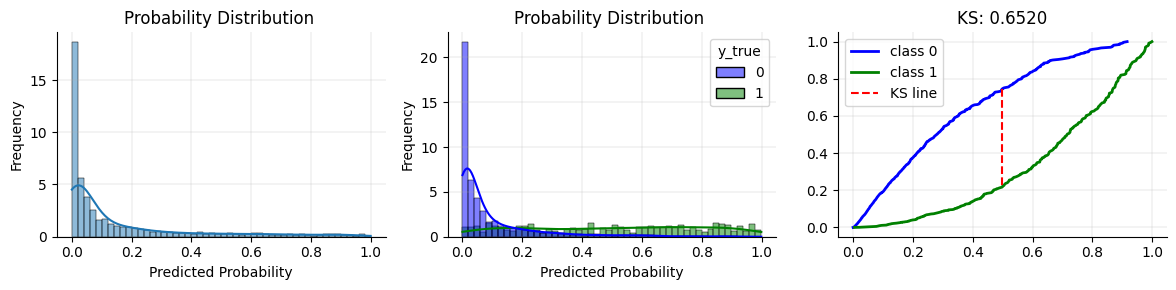

In [ ]:

# 🎛️ Parâmetros de controle
SAMPLE_SIZE = 10000           # tamanho da amostra
DEFAULT_RATE_TARGET = 0.03# percentual desejado de inadimplência (ex: 0.15 = 15%)
NOISE_SCALE = 0            # nível de ruído para a função logística

# Fixar a semente para reprodutibilidade
np.random.seed(42)

# 🔢 Variáveis explicativas simuladas
age = np.random.randint(18, 70, size=SAMPLE_SIZE)
income = np.random.normal(5000, 2000, size=SAMPLE_SIZE).clip(1000, 20000)
loan_amount = np.random.normal(20000, 10000, size=SAMPLE_SIZE).clip(5000, 100000)
loan_term = np.random.choice([12, 24, 36, 48, 60], size=SAMPLE_SIZE)
employment_status = np.random.choice(['CLT', 'autônomo', 'desempregado'], size=SAMPLE_SIZE, p=[0.6, 0.3, 0.1])
credit_score = np.random.normal(600, 100, size=SAMPLE_SIZE).clip(300, 850)
region = np.random.choice(['Norte', 'Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste'], size=SAMPLE_SIZE)
past_due_days = np.random.poisson(5, size=SAMPLE_SIZE)

# 🔁 Codificar variáveis categóricas para modelagem (exemplo simplificado)
employment_map = {'CLT': 0, 'autônomo': 1, 'desempregado': 2}
employment_encoded = pd.Series(employment_status).map(employment_map).values

# 🎯 Simular probabilidade de default ajustada à taxa-alvo
# Fórmula logística base com ruído
logit_base = (
    -6.0
    - 0.01 * credit_score             # impacto maior do score
    + 0.0002 * loan_amount            # maior valor = mais risco
    - 0.0003 * income                 # mais renda = menos risco
    + 0.5 * employment_encoded        # peso alto p/ desempregado
    + NOISE_SCALE * np.random.normal(0, 1, SAMPLE_SIZE)
)

# Ajustar intercepto para atingir a taxa de default desejada

def adjust_intercept(intercept):
    logits = logit_base + intercept
    probs = 1 / (1 + np.exp(-logits))
    return abs(probs.mean() - DEFAULT_RATE_TARGET)

res = minimize_scalar(adjust_intercept, bounds=(-10, 10), method='bounded')
optimal_intercept = res.x

# Calcular probabilidade final e simular default
logits = logit_base + optimal_intercept
default_prob = 1 / (1 + np.exp(-logits))
default = np.random.binomial(1, default_prob)

# 📉 Simular LGD (apenas para inadimplentes)
lgd = np.where(default == 1, np.random.beta(2, 5, size=SAMPLE_SIZE), 0)

# 💰 Simular EAD
ead = loan_amount * np.random.uniform(0.8, 1.2, size=SAMPLE_SIZE)

# 📌 Perda realizada
realized_loss = default * lgd * ead

# 📋 Criar DataFrame final
df = pd.DataFrame({
    'age': age,
    'income': income,
    'loan_amount': loan_amount,
    'loan_term': loan_term,
    'employment_status': employment_status,
    'credit_score': credit_score,
    'region': region,
    'past_due_days': past_due_days,
    'default': default,
    'lgd': lgd,
    'ead': ead,
    'realized_loss': realized_loss
})

# 🔍 Verificar taxa final de inadimplência
actual_default_rate = df['default'].mean()
print(f"Taxa de inadimplência simulada: {actual_default_rate:.2%}")

# Copiar base original para modelagem
df_model = df.copy()

# --- One-hot encoding com verificação de colunas esperadas ---
expected_dummies = [
    'employment_status_autônomo', 'employment_status_desempregado',
    'region_Nordeste', 'region_Sudeste', 'region_Sul', 'region_Centro-Oeste'
]

# Codificar as variáveis categóricas
df_model = pd.get_dummies(df_model, columns=['employment_status', 'region'], drop_first=True)

# Garantir que todas as colunas esperadas existam
for col in expected_dummies:
    if col not in df_model.columns:
        df_model[col] = 0

# Selecionar features para PD
features = [
    'age', 'income', 'loan_amount', 'loan_term',
    'credit_score', 'past_due_days'
] + expected_dummies

# Variáveis X, y e peso
X = df_model[features]
y = df_model['default']
sample_weight = df_model['ead']  # ponderar pelo valor exposto

# Dividir entre treino e teste
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight, test_size=0.3, stratify=y, random_state=42
)

# Regressão logística
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)

# Previsão da PD no conjunto de teste
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Criar DataFrame com resultado
df_resultado = X_test.copy()
df_resultado['default_real'] = y_test.values
df_resultado['pd_estimada'] = y_pred_proba
df_resultado['ead'] = w_test.values

# y_test, y_pred_proba
print(f"Test set size: {len(y_test)}")
print(f"Esposição: {y_test.sum()/len(y_test)*100:.2f}%")


df_classifier= pd.DataFrame({'y_true': y_test, 'score': y_pred_proba})

df_classifier= pd.DataFrame({'y_true': y_test, 'score': y_pred_proba})
mask0 = (y_test==0)
class0 = y_pred_proba[mask0]
class1 = y_pred_proba[~mask0]
ks = ks_2samp(class0, class1).statistic

cdf_ = get_classes_cdf(df=df_classifier, proba_col='score', true_value_col='y_true')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax1, ax2, ax3 = ax.flatten()
plot_hist(df_classifier, 'Probability Distribution ', ax1, hue=False)
plot_hist(df_classifier, 'Probability Distribution ', ax2, color0='b', color1='g')
plot_cdf_ks(cdf_, ks, ax3, color0='b', color1='g')
plt.tight_layout()
plt.show()



In [29]:
# ➕ Trazer LGD e perda realizada para o conjunto de teste
df_test_info = df.loc[y_test.index, ['lgd', 'realized_loss']]
df_resultado['lgd_real'] = df_test_info['lgd'].values
df_resultado['loss_realizada'] = df_test_info['realized_loss'].values

# 📈 Calcular perda esperada
df_resultado['loss_esperada'] = df_resultado['pd_estimada'] * df_resultado['lgd_real'] * df_resultado['ead']


# 🔍 Comparar a soma total das perdas
loss_total_realizada = df_resultado['loss_realizada'].sum()
loss_total_estimada = df_resultado['loss_esperada'].sum()

# 🧮 Calcular diferença absoluta e percentual
diferenca = loss_total_estimada - loss_total_realizada
percentual = abs(diferenca / loss_total_realizada) * 100

# 🖨️ Mostrar resultado
print(f"🔎 Perda total estimada:   R$ {loss_total_estimada:,.2f}")
print(f"📌 Perda total realizada:  R$ {loss_total_realizada:,.2f}")
print(f"📈 Diferença absoluta:     R$ {diferenca:,.2f}")
print(f"📉 Diferença percentual:   {percentual:.2f}%")
print("⬆ Modelo superestimou a perda." if diferenca > 0 else "⬇ Modelo subestimou a perda.")


🔎 Perda total estimada:   R$ 269,143.26
📌 Perda total realizada:  R$ 892,053.32
📈 Diferença absoluta:     R$ -622,910.05
📉 Diferença percentual:   69.83%
⬇ Modelo subestimou a perda.


---

## 🎯 Ajuste do Score de PD e Impacto na Perda Esperada

Após treinar o modelo de **PD (Probability of Default)** com regressão logística e comparar as perdas estimadas com as perdas realizadas, aplicamos uma **transformação nos scores preditos** com o objetivo de:

- Observar o efeito de um **recalibramento** ou **"ajuste escalar"** sobre as estimativas de perda;
- Estudar como diferentes níveis de **agressividade do score** afetam a acurácia da mensuração da **perda esperada total**;
- Verificar qual constante produz a menor discrepância percentual entre a **perda estimada** e a **perda realizada**.

### 🧮 Fórmula de Ajuste Aplicada

A transformação aplicada à PD estimada é a seguinte:

$$
\text{PD}_{ajustada} = \frac{c \cdot \text{PD}_{modelo}}{c \cdot \text{PD}_{modelo} + (1 - \text{PD}_{modelo})}
$$

Onde:
- $\text{PD}_{modelo}$ é a probabilidade predita pelo modelo original.
- $c$ é uma **constante de ajuste** variando entre 20 e 39.

Esta fórmula tem origem na ideia de **calibração log-odds**, frequentemente associada ao conceito de **Platt scaling** e ajustes de **isotonic regression**, ainda que aqui seja aplicada uma versão escalar direta sobre as razões de chances (odds ratio):

$$
\text{Odds}_{ajustada} = c \cdot \text{Odds}_{modelo}
$$

E como:

$$
\text{PD} = \frac{\text{Odds}}{1 + \text{Odds}} \Rightarrow \text{PD}_{ajustada} = \frac{c \cdot \text{Odds}_{modelo}}{1 + c \cdot \text{Odds}_{modelo}}
$$

Essa técnica é uma forma de testar cenários em que o modelo pode estar **subestimando ou superestimando** o risco de inadimplência.

---

## 🧪 Mensuração do Impacto

Para cada valor de $c$ no intervalo de 20 a 39, realizamos:

1. **Reajuste do score de PD** com a fórmula acima.
2. **Reestimativa da perda esperada**:

$$
\text{Expected Loss} = PD_{ajustada} \times LGD \times EAD
$$

3. Comparação da **perda total esperada** com a **perda total realizada**:

```python
diferença = perda_esperada_total - perda_realizada_total
percentual = abs(diferenca / perda_realizada_total) * 100
```



In [ ]:
for c in range(20,40):
    
    output_modelo = 'pd_estimada'
    vr = 'default_real'

    df_resultado['pd_ajustada'] = (df_resultado['pd_estimada']*c)/((df_resultado['pd_estimada']*c)+(1-df_resultado['pd_estimada']))


    # ➕ Trazer LGD e perda realizada para o conjunto de teste
    df_test_info = df.loc[y_test.index, ['lgd', 'realized_loss']]
    df_resultado['lgd_real'] = df_test_info['lgd'].values
    df_resultado['loss_realizada'] = df_test_info['realized_loss'].values

    # 📈 Calcular perda esperada
    df_resultado['loss_esperada'] = df_resultado['pd_ajustada'] * df_resultado['lgd_real'] * df_resultado['ead']


    # 🔍 Comparar a soma total das perdas
    loss_total_realizada = df_resultado['loss_realizada'].sum()
    loss_total_estimada = df_resultado['loss_esperada'].sum()

    # 🧮 Calcular diferença absoluta e percentual
    diferenca = loss_total_estimada - loss_total_realizada
    percentual = abs(diferenca / loss_total_realizada) * 100

    # 🖨️ Mostrar resultado
    # print(f"🔎 Perda total estimada:   R$ {loss_total_estimada:,.2f}")
    # print(f"📌 Perda total realizada:  R$ {loss_total_realizada:,.2f}")
    # print(f"📈 Diferença absoluta:     R$ {diferenca:,.2f}")
    print(f"📉 Constante: {c} - Diferença percentual:   {percentual:.2f}%")
    print("⬆ Modelo superestimou a perda." if diferenca > 0 else "⬇ Modelo subestimou a perda.")


📉 Constante: 20 - Diferença percentual:   23.49%
⬇ Modelo subestimou a perda.
📉 Constante: 21 - Diferença percentual:   22.86%
⬇ Modelo subestimou a perda.
📉 Constante: 22 - Diferença percentual:   22.27%
⬇ Modelo subestimou a perda.
📉 Constante: 23 - Diferença percentual:   21.72%
⬇ Modelo subestimou a perda.
📉 Constante: 24 - Diferença percentual:   21.20%
⬇ Modelo subestimou a perda.
📉 Constante: 25 - Diferença percentual:   20.71%
⬇ Modelo subestimou a perda.
📉 Constante: 26 - Diferença percentual:   20.24%
⬇ Modelo subestimou a perda.
📉 Constante: 27 - Diferença percentual:   19.80%
⬇ Modelo subestimou a perda.
📉 Constante: 28 - Diferença percentual:   19.37%
⬇ Modelo subestimou a perda.
📉 Constante: 29 - Diferença percentual:   18.97%
⬇ Modelo subestimou a perda.
📉 Constante: 30 - Diferença percentual:   18.59%
⬇ Modelo subestimou a perda.
📉 Constante: 31 - Diferença percentual:   18.23%
⬇ Modelo subestimou a perda.
📉 Constante: 32 - Diferença percentual:   17.88%
⬇ Modelo subest

Pontos de interpolação KS:
ks_x: 0.7176231238953044, ks_y0: 0.6671300629911817, ks_y1: 0.09667296597166496
proba0 range: 0.0001906417211597397 - 0.9902376278806488
proba1 range: 0.14883903574436458 - 0.9988481466381185


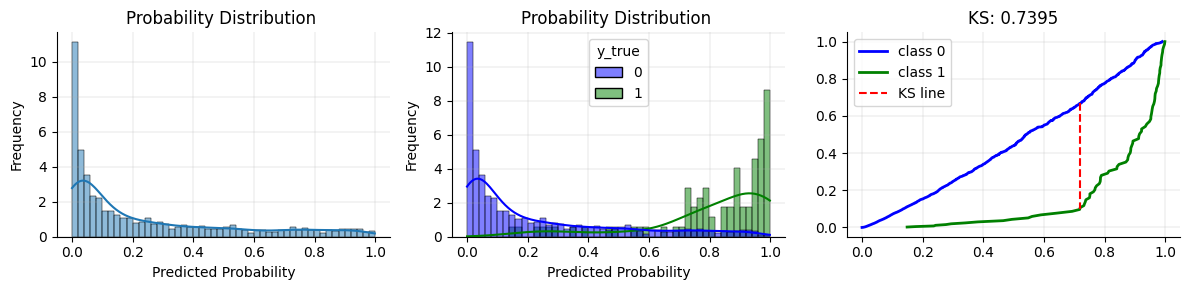

In [32]:

df_classifier= pd.DataFrame(
    {'y_true': df_resultado[vr], 
     'score':  df_resultado['pd_ajustada']
     })

mask0 = (df_resultado[vr]==0)
class0 = df_resultado['pd_ajustada'][mask0]
class1 = df_resultado['pd_ajustada'][~mask0]
ks = ks_2samp(class0, class1).statistic

cdf_ = get_classes_cdf(df=df_resultado, proba_col='pd_ajustada', true_value_col=vr)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax1, ax2, ax3 = ax.flatten()
plot_hist(df_classifier, 'Probability Distribution ', ax1, hue=False)
plot_hist(df_classifier, 'Probability Distribution ', ax2, color0='b', color1='g')
plot_cdf_ks(cdf_, ks, ax3, color0='b', color1='g')
plt.tight_layout()
plt.show()